### Required Discussion 19:1: Building a Recommender System with SURPRISE

This discussion focuses on exploring additional algorithms with the `Suprise` library to generate recommendations.  Your goal is to identify the optimal algorithm by minimizing the mean squared error using cross validation. You are also going to select a dataset to use from [grouplens](https://grouplens.org/datasets/movielens/) example datasets.  

To begin, head over to [grouplens](https://grouplens.org/datasets/movielens/) and examine the different datasets available.  Choose one so that it is easy to create the data as expected in `Surprise` with user, item, and rating information.  Then, compare the performance of at least the `KNNBasic`, `SVD`, `NMF`, `SlopeOne`, and `CoClustering` algorithms to build your recommendations.  For more information on the algorithms see the documentation for the algorithm package [here](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html).

Share the results of your investigation and include the results of your cross validation and a basic description of your dataset with your peers.


In [1]:
from surprise import Dataset, Reader, SVD, NMF, KNNBasic, SlopeOne, CoClustering
from surprise.model_selection import cross_validate

import pandas as pd

In [2]:
# Read the sampled ratings data and movies metadata
ratings = pd.read_csv('data/ratings-256k.csv')
movies = pd.read_csv('data/ml-32m/movies.csv')

print(f"Dataset loaded: {len(ratings):,} ratings, {ratings['userId'].nunique():,} users, {ratings['movieId'].nunique():,} movies")

Dataset loaded: 262,144 ratings, 102,430 users, 16,462 movies


In [3]:
movies.info()
movies.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


,movieId
count,87585.000000
mean,157651.365519
std,79013.402099
min,1.000000
25%,112657.000000
50%,165741.000000
75%,213203.000000
max,292757.000000


In [4]:
ratings.info()
ratings.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     262144 non-null  int64  
 1   movieId    262144 non-null  int64  
 2   rating     262144 non-null  float64
 3   timestamp  262144 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 8.0 MB


,userId,movieId,rating,timestamp
count,262144.000000,262144.000000,262144.000000,2.621440e+05
mean,100180.841484,29166.701164,3.539732,1.274791e+09
std,57836.614843,50739.699581,1.059769,2.560741e+08
min,9.000000,1.000000,0.500000,8.231852e+08
25%,50092.000000,1230.000000,3.000000,1.050949e+09
50%,100024.000000,3439.000000,3.500000,1.271627e+09
75%,150219.250000,44191.000000,4.000000,1.502760e+09
max,200948.000000,292755.000000,5.000000,1.697164e+09


In [5]:
# Reduce dataset size in memory (Kernel crashed on Macbook M4) 
print(f"Original size: {len(ratings):,} ratings")

# Sample down to 128*1024 = 131,072 entries
target_size = 128 * 1024
ratings = ratings.sample(n=target_size, random_state=42).reset_index(drop=True)

print(f"Reduced size: {len(ratings):,} ratings")
print(f"Users: {ratings['userId'].nunique():,}, Movies: {ratings['movieId'].nunique():,}")

# Recreate SURPRISE dataset with smaller data
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
print("SURPRISE dataset recreated with smaller sample")

Original size: 262,144 ratings
Reduced size: 131,072 ratings
Users: 70,248, Movies: 12,463
SURPRISE dataset recreated with smaller sample


In [6]:
from surprise import Dataset, Reader

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
print("SURPRISE dataset created")

SURPRISE dataset created


In [7]:
algorithms = {
    'KNNBasic': KNNBasic(),
    'SVD': SVD(),
    'NMF': NMF(),
    'SlopeOne': SlopeOne(),
    'CoClustering': CoClustering()
}
print(f"Algorithms defined: {list(algorithms.keys())}")

Algorithms defined: ['KNNBasic', 'SVD', 'NMF', 'SlopeOne', 'CoClustering']


In [8]:
import time

print("Running cross-validation...")
results = {}
times = {}

for name, algo in algorithms.items():
    print(f"Testing {name}...", end=" ")
    
    start_time = time.time()
    cv_results = cross_validate(algo, data, measures=['MSE'], cv=5, verbose=False)
    end_time = time.time()
    
    results[name] = cv_results['test_mse'].mean()
    times[name] = end_time - start_time
    
    print(f"completed in {times[name]:.1f} seconds")

print("Cross-validation complete")

Running cross-validation...
Testing KNNBasic... Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
completed in 182.5 seconds
Testing SVD... completed in 4.6 seconds
Testing NMF... completed in 15.4 seconds
Testing SlopeOne... completed in 4.3 seconds
Testing CoClustering... completed in 14.4 seconds
Cross-validation complete


In [9]:
print("=== ALGORITHM COMPARISON ===")
print(f"{'Algorithm':<12} {'MSE':<8} {'Time (s)':<8}")
print("-" * 30)

for name, mse in sorted(results.items(), key=lambda x: x[1]):
    print(f"{name:<12} {mse:<8.4f} {times[name]:<8.1f}")

best_algo = min(results, key=results.get)
fastest_algo = min(times, key=times.get)

print(f"\nOptimal algorithm (MSE): {best_algo} ({results[best_algo]:.4f})")
print(f"Fastest algorithm: {fastest_algo} ({times[fastest_algo]:.1f}s)")

=== ALGORITHM COMPARISON ===
Algorithm    MSE      Time (s)
------------------------------
SVD          0.9401   4.6     
KNNBasic     1.1431   182.5   
CoClustering 1.2892   14.4    
NMF          1.3136   15.4    
SlopeOne     1.3331   4.3     

Optimal algorithm (MSE): SVD (0.9401)
Fastest algorithm: SlopeOne (4.3s)


=== RESULTS SUMMARY ===
      Algorithm     MSE  Time (s)
0      KNNBasic  1.1431  182.5138
1           SVD  0.9401    4.6393
2           NMF  1.3136   15.3642
3      SlopeOne  1.3331    4.2854
4  CoClustering  1.2892   14.4065


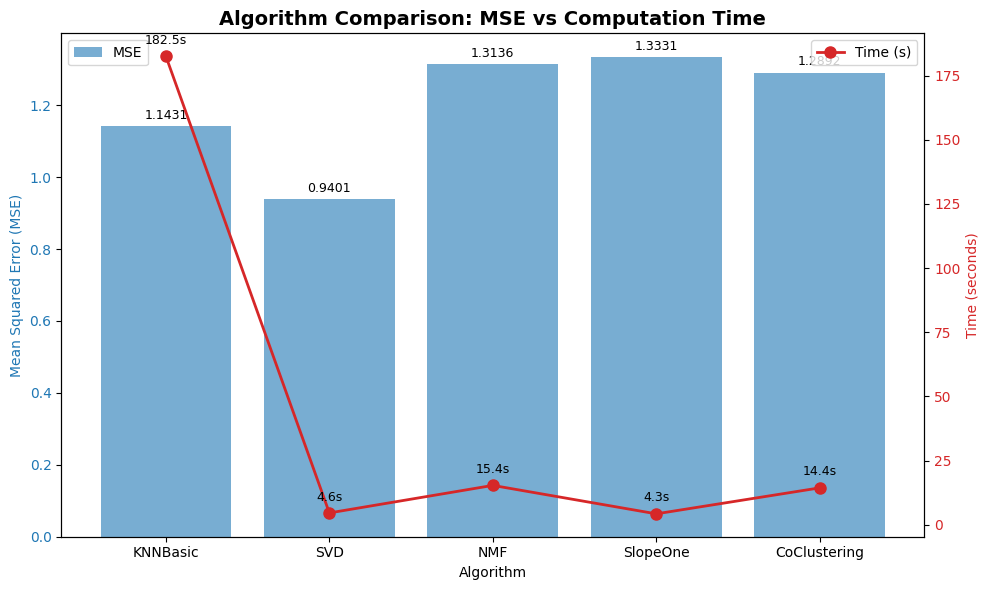

In [10]:
import matplotlib.pyplot as plt

# Create DataFrame for plotting
df_results = pd.DataFrame({
    'Algorithm': list(results.keys()),
    'MSE': list(results.values()),
    'Time (s)': [times[algo] for algo in results.keys()]
})

print("=== RESULTS SUMMARY ===")
print(df_results.round(4))

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

# MSE bars
color = 'tab:blue'
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Mean Squared Error (MSE)', color=color)
bars = ax1.bar(df_results['Algorithm'], df_results['MSE'], color=color, alpha=0.6, label='MSE')
ax1.tick_params(axis='y', labelcolor=color)

# Add MSE values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Time line plot on second y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Time (seconds)', color=color)
line = ax2.plot(df_results['Algorithm'], df_results['Time (s)'], 
                color=color, marker='o', linewidth=2, markersize=8, label='Time (s)')
ax2.tick_params(axis='y', labelcolor=color)

# Add time values on points
for i, (algo, time_val) in enumerate(zip(df_results['Algorithm'], df_results['Time (s)'])):
    ax2.text(i, time_val + max(df_results['Time (s)'])*0.02, 
             f'{time_val:.1f}s', ha='center', va='bottom', fontsize=9)

plt.title('Algorithm Comparison: MSE vs Computation Time', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
fig.tight_layout()

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [11]:
# Most rated movies in our sample
movie_counts = ratings['movieId'].value_counts().head(10)
popular_movies = movies[movies['movieId'].isin(movie_counts.index)][['movieId', 'title']]
popular_movies = popular_movies.merge(movie_counts.to_frame('ratings'), left_on='movieId', right_index=True)
print("Most rated movies in sample:")
print(popular_movies.sort_values('ratings', ascending=False))

Most rated movies in sample:
      movieId                                          title  ratings
351       356                            Forrest Gump (1994)      421
314       318               Shawshank Redemption, The (1994)      415
292       296                            Pulp Fiction (1994)      396
2480     2571                             Matrix, The (1999)      387
257       260      Star Wars: Episode IV - A New Hope (1977)      375
585       593               Silence of the Lambs, The (1991)      366
5841     5952  Lord of the Rings: The Two Towers, The (2002)      304
475       480                           Jurassic Park (1993)      302
2867     2959                              Fight Club (1999)      297
581       589              Terminator 2: Judgment Day (1991)      293


In [12]:
# Train best algorithm and show sample predictions
best_model = SVD()  # assuming SVD won
trainset = data.build_full_trainset()
best_model.fit(trainset)

# Get sample predictions with movie names
sample_user = ratings['userId'].iloc[0]
user_items = ratings[ratings['userId'] == sample_user]['movieId'].values
unrated_items = movies[~movies['movieId'].isin(user_items)]['movieId'].sample(5)

print(f"\nSample recommendations for user {sample_user}:")
for item in unrated_items:
    pred = best_model.predict(sample_user, item)
    movie_name = movies[movies['movieId'] == item]['title'].iloc[0]
    print(f"{movie_name}: {pred.est:.2f}")


Sample recommendations for user 53590:
Mask of the Avenger (1951): 3.59
The Quiet One (2019): 3.59
Обмін (2022): 3.59
Mystery 101 (2019): 3.59
Jungle Captive (1945): 3.59


In [13]:
from surprise.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Parameter grids (reasonable for 128K data)
param_grids = {
    'SVD': {
        'n_factors': randint(50, 100),
        'n_epochs': randint(15, 25), 
        'lr_all': uniform(0.005, 0.01),
        'reg_all': uniform(0.02, 0.05)
    },
    'NMF': {
        'n_factors': randint(15, 40),
        'n_epochs': randint(20, 40)
    },
    'KNNBasic': {
        'k': randint(20, 50),
        'sim_options': {'name': ['msd', 'cosine'], 'user_based': [True, False]}
    },
    'CoClustering': {
        'n_cltr_u': randint(3, 8),
        'n_cltr_i': randint(3, 8)
    }
}

# Hyperparameter search with timing
tuned_algos = {}
search_times = {}

for name, params in param_grids.items():
    print(f"Tuning {name}...")
    start = time.time()
    rs = RandomizedSearchCV(algorithms[name].__class__, params, 
                           measures=['mse'], cv=3, n_iter=10, random_state=42)
    rs.fit(data)
    search_times[name] = time.time() - start
    tuned_algos[name] = rs.best_estimator['mse']
    print(f"Best MSE: {rs.best_score['mse']:.4f}, Time: {search_times[name]:.1f}s")

# Add SlopeOne (no tuning needed)
tuned_algos['SlopeOne'] = SlopeOne()
search_times['SlopeOne'] = 0

Tuning SVD...
Best MSE: 0.9298, Time: 18.2s
Tuning NMF...
Best MSE: 1.2472, Time: 65.4s
Tuning KNNBasic...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarit

Evaluating tuned algorithms...
Final evaluation of SVD...
Final evaluation of NMF...
Final evaluation of KNNBasic...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Final evaluation of CoClustering...
Final evaluation of SlopeOne...
=== FINAL RESULTS ===
      Algorithm  Final MSE  Search Time (s)  Fit Time (s)  Test Time (s)
0           SVD      0.921           18.155         2.675          0.289
1           NMF      1.242           65.447        14.164          0.568
2      KNNBasic      1.141          701.459         1.986          0.524
3  CoClustering      1.293          114.371        15.390          0.262
4      SlopeOne      1.328            0.000         2.815      

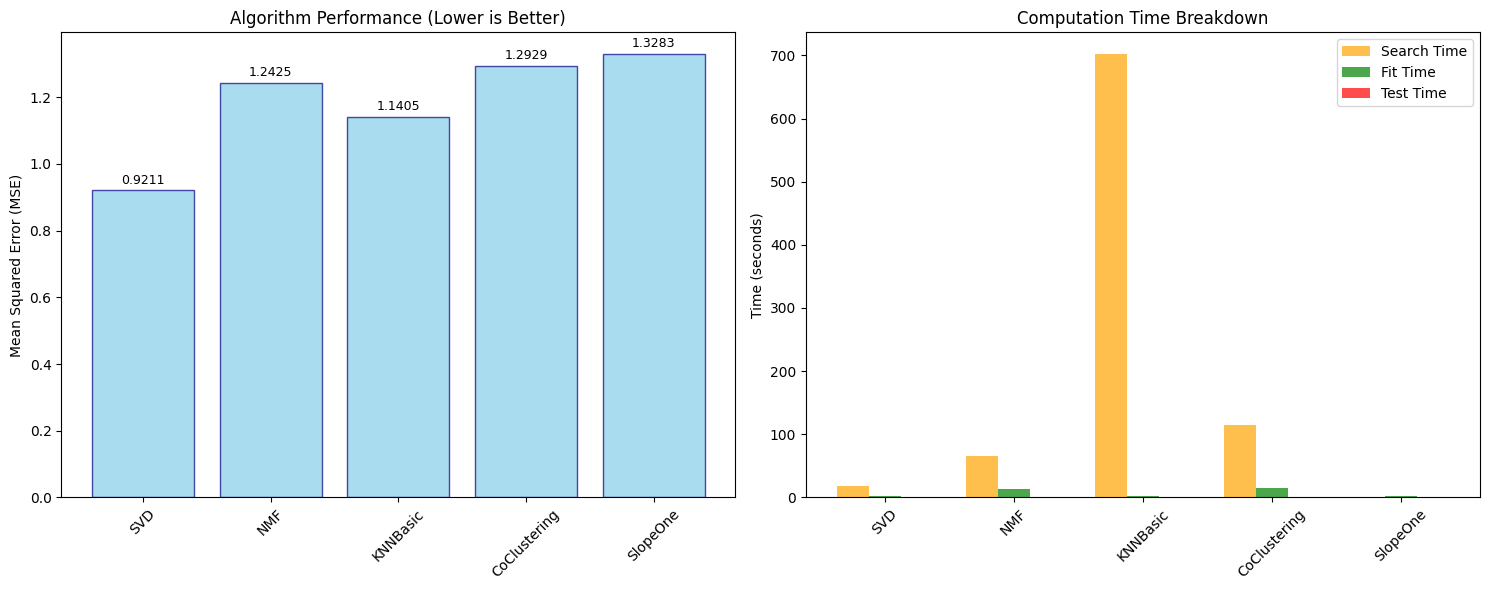


 OPTIMAL ALGORITHM: SVD
   MSE: 0.9211
   Total Time: 20.8s


In [17]:
# First, evaluate the tuned algorithms with cross-validation
print("Evaluating tuned algorithms...")
final_results = {}
final_fit_times = {}
final_test_times = {}

for name, algo in tuned_algos.items():
    print(f"Final evaluation of {name}...")
    cv_results = cross_validate(algo, data, measures=['MSE'], cv=5, verbose=False)
    
    final_results[name] = cv_results['test_mse'].mean()
    final_fit_times[name] = sum(cv_results['fit_time'])
    final_test_times[name] = sum(cv_results['test_time'])

# Create comprehensive DataFrame
df_results = pd.DataFrame({
    'Algorithm': list(final_results.keys()),
    'Final MSE': list(final_results.values()),
    'Search Time (s)': [search_times[algo] for algo in final_results.keys()],
    'Fit Time (s)': [final_fit_times[algo] for algo in final_results.keys()],
    'Test Time (s)': [final_test_times[algo] for algo in final_results.keys()]
})

print("=== FINAL RESULTS ===")
print(df_results.round(3))

# Enhanced visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: MSE comparison
ax1.bar(df_results['Algorithm'], df_results['Final MSE'], color='skyblue', alpha=0.7, edgecolor='navy')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.set_title('Algorithm Performance (Lower is Better)')
ax1.tick_params(axis='x', rotation=45)

# Add MSE values on bars
for i, (algo, mse) in enumerate(zip(df_results['Algorithm'], df_results['Final MSE'])):
    ax1.text(i, mse + mse*0.01, f'{mse:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Timing comparison
width = 0.25
x = range(len(df_results))

ax2.bar([i-width for i in x], df_results['Search Time (s)'], width, label='Search Time', color='orange', alpha=0.7)
ax2.bar(x, df_results['Fit Time (s)'], width, label='Fit Time', color='green', alpha=0.7)
ax2.bar([i+width for i in x], df_results['Test Time (s)'], width, label='Test Time', color='red', alpha=0.7)

ax2.set_ylabel('Time (seconds)')
ax2.set_title('Computation Time Breakdown')
ax2.set_xticks(x)
ax2.set_xticklabels(df_results['Algorithm'], rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

# Find optimal algorithm
best_algo = df_results.loc[df_results['Final MSE'].idxmin()]
print(f"\n OPTIMAL ALGORITHM: {best_algo['Algorithm']}")
print(f"   MSE: {best_algo['Final MSE']:.4f}")
print(f"   Total Time: {best_algo['Search Time (s)'] + best_algo['Fit Time (s)']:.1f}s")